In [293]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

class Equalizator:

    def __init__(self, image_path):
        self.path = image_path
        self.image = cv2.imread(image_path, 0)
        self.levels, self.counts = np.unique(self.image[::], return_counts=np.uint32)
        self.levels = dict(zip(self.levels, self.counts))
        self.count_of_pixels = np.prod(self.image.shape)

    def get_probabilities_of_pixels(self, count_of_pixels, level_range=(0, 256)):
        return np.array([self.levels.get(i, 0) / count_of_pixels for i in range( *level_range )])

    def get_cumulative_density_f(self, probabilities):
        density = np.array([])
        for i in range(len(probabilities)):
            density = np.append(density, np.sum(probabilities[:i]))
        return density

    def HE(self):
        P = self.get_probabilities_of_pixels(self.count_of_pixels)
        density = self.get_cumulative_density_f(P)
        res = np.zeros((self.image.shape[0], self.image.shape[1], 1), dtype=np.uint8)
        levels = list(self.levels.keys())
        x0 = min(levels)
        xl_1 = max(levels)
        for i in range(self.image.shape[0]):
            for j in range(self.image.shape[1]):
                res[i][j] = x0 + (xl_1 - x0) * density[self.image[i, j]]
        return res

    def two_images_into_one(self, density_d, density_l, mean, x0, xl_1):
        res_image = np.zeros((self.image.shape[0], self.image.shape[1], 1), dtype=np.uint8)
        for i in range(self.image.shape[0]):
            for j in range(self.image.shape[1]):
                if self.image[i, j] <= mean:
                    res_image[i, j] = x0 + (mean - x0) * density_d[self.image[i, j] - x0]
                else:
                    res_image[i, j] = mean + 1 + (xl_1 - mean) * density_l[self.image[i, j] - mean - 1]
        return res_image

    def BBHE(self, mean=-1):
        if mean == -1:
            mean = int(cv2.mean(self.image)[0])
        ND = np.sum(np.select([self.image <= mean, self.image > mean], [1, 0]))
        NL = np.sum(np.select([self.image > mean, self.image <= mean], [1, 0]))
        levels = list(self.levels.keys())
        x0 = min(levels)
        xl_1 = max(levels)
        prob_d = self.get_probabilities_of_pixels(ND, (x0, mean + 1))
        prob_l = self.get_probabilities_of_pixels(NL, (mean + 1, xl_1 + 1))
        density_d = self.get_cumulative_density_f(prob_d)
        density_l = self.get_cumulative_density_f(prob_l)
        return self.two_images_into_one(density_d, density_l, mean, x0, xl_1)

    def find_prob_divider(levels):
        right, left = 0, 1
        for level in range(256):
            right += levels[level]
            left -= levels[level]
            if right > left:
                break
        return level

    def find_min_mbe(self, counts):
        N = np.sum(counts)
        Ex = np.sum([level * counts[level] for level in range(256)]) << 1
        current = ((N - counts[0]) << 8) - Ex
        min = abs(current)
        min_i = 0
        for i in range(1, 256):
            current += (N - (counts[i] << 8))
            if abs(current) < min:
                min = abs(current)
                min_i = i
        return min_i

    def DSIHE(self):
        mean = Equalizator.find_prob_divider(self.get_probabilities_of_pixels(self.count_of_pixels))
        return  self.BBHE(mean)

    def MMBEBHE(self):
        counts = [self.levels.get(level, 0) for level in range(256)]
        mean = self.find_min_mbe(counts)
        return self.BBHE(mean)

In [294]:
image_path = "test/hist.png"
a = Equalizator(image_path)

In [295]:
image = cv2.imread(image_path, 0)

In [296]:
HE = a.HE()

In [297]:
BBHE = a.BBHE()

In [298]:
DSIHE = a.DSIHE()

In [299]:
MMBEBHE = a.MMBEBHE()

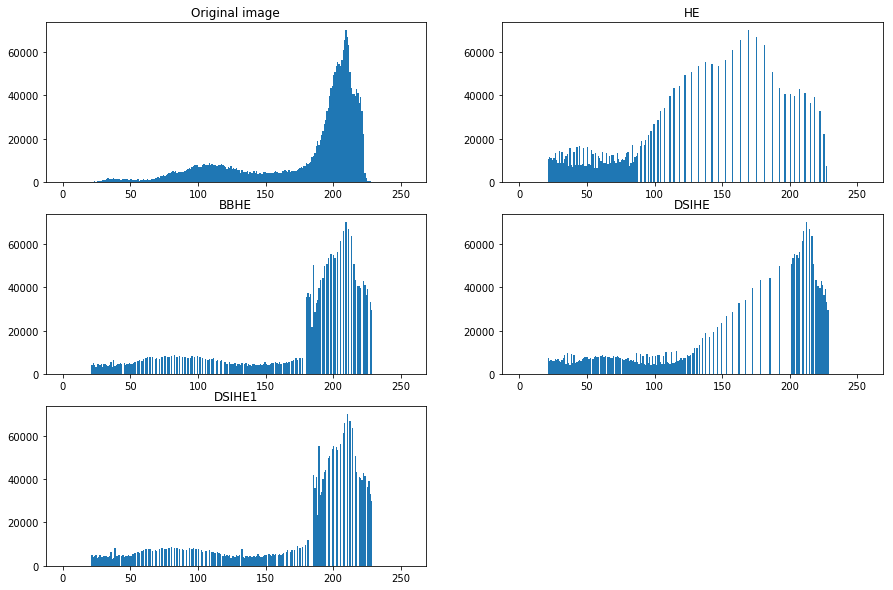

In [300]:
f, axarr = plt.subplots(3, 2, figsize = (15,10))
axarr[0, 0].hist(image.ravel(), 256, [0, 256])
axarr[0, 0].set_title("Original image")
axarr[0, 1].hist(HE.ravel(), 256, [0, 256])
axarr[0, 1].set_title("HE")
axarr[1, 0].hist(BBHE.ravel(), 256, [0, 256])
axarr[1, 0].set_title("BBHE")
axarr[1, 1].hist(DSIHE.ravel(), 256, [0, 256])
axarr[1, 1].set_title("DSIHE")
axarr[2, 0].hist(MMBEBHE.ravel(), 256, [0, 256])
axarr[2, 0].set_title("DSIHE1")
f.delaxes(axarr[2, 1])
plt.show()

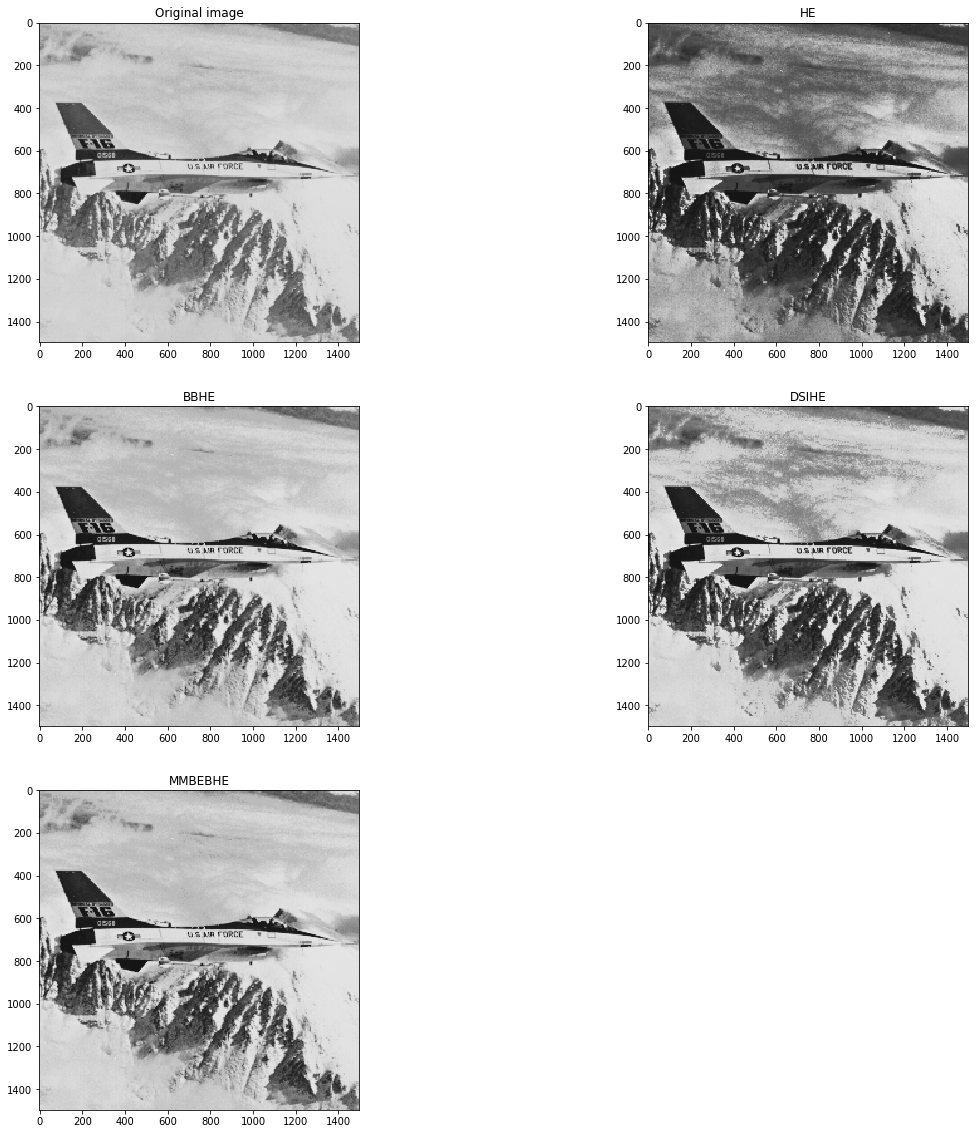

In [301]:
f, axarr = plt.subplots(3, 2, figsize = (20,20))
axarr[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axarr[0, 0].set_title("Original image")
axarr[0, 1].imshow(cv2.cvtColor(HE, cv2.COLOR_BGR2RGB))
axarr[0, 1].set_title("HE")
axarr[1, 0].imshow(cv2.cvtColor(BBHE, cv2.COLOR_BGR2RGB))
axarr[1, 0].set_title("BBHE")
axarr[1, 1].imshow(cv2.cvtColor(DSIHE, cv2.COLOR_BGR2RGB))
axarr[1, 1].set_title("DSIHE")
axarr[2, 0].imshow(cv2.cvtColor(MMBEBHE, cv2.COLOR_BGR2RGB))
axarr[2, 0].set_title("MMBEBHE")
f.delaxes(axarr[2, 1])
plt.show()